---
title: Stable diffusion using 🤗 Hugging Face - Variations of Stable Diffusion
author: Aayush Agrawal
date: "1999-11-11"
categories: [Stable Diffusion]
image: "./diverging_roads.png"
format:
    html:
        code-fold: false
        number-sections: true
---

> An introduction to the diffusion process using  🤗 [hugging face diffusers library](https://github.com/huggingface/diffusers).

This is my third post of the Stable diffusion series, if you haven't checked out the first one, you can read it here - <br>
1. **Part 1** - [Stable diffusion using 🤗 Hugging Face - Introduction](https://aayushmnit.com/posts/2022-11-02-StabeDiffusionP1/2022-11-02-StableDiffusionP1.html). <br>
2. **Part 2** - [Stable diffusion using 🤗 Hugging Face - Looking under the hood](https://aayushmnit.com/posts/2022-11-05-StableDiffusionP2/2022-11-05-StableDiffusionP2.html). <br>
3. **Part 3** - [Stable diffusion using 🤗 Hugging Face - Putting everything together](https://aayushmnit.com/posts/2022-11-07-StableDiffusionP3/2022-11-07-StableDiffusionP3.html)

In previous posts, I went over all key components of Stable Diffusion and how to get a prompt to image pipeline working. In this post, I will show how to edit the prompt to image function to add additional functionality to our Stable diffusion pipeline i.e. `Negative prompting` and `Imgage to Image` pipeline. Hopefully this will provide enough motivation to play around this function and doing your own research. 

<figure align = "center">
<img src="./diverging_roads.png" style="width:100%">
<figcaption align = "center">
        Fig. 1: A Stable diffusion generated image using prompt -  <br>"A road diverging in two different direction"
</figcaption>
</figure>

## Variation 1: Negative Prompt

### What is negative prompting?

A negative prompt is a additional capability we can add to our model to tell the stable diffusion model what we doesn't want to see in the generated image. This feature is extremely popular to remove anything a user doesn't want to see from the original image. 

<figure align = "center">
    <img src="./negative_prompt_example.png" style="width:100%">
<figcaption align = "center">
        Fig. 2: Negative prompt example
</figcaption>
</figure>

###  Understanding negative prompting through code

Let's start by importing the required libraries and helper functions. All of this was already used and explained in the previous [part 2](https://aayushmnit.com/posts/2022-11-05-StableDiffusionP2/2022-11-05-StableDiffusionP2.html) and [part 3](https://aayushmnit.com/posts/2022-11-07-StableDiffusionP3/2022-11-07-StableDiffusionP3.html) of the series.

In [5]:
#| code-fold: true
import torch, logging

## disable warnings
logging.disable(logging.WARNING)  

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms


## Basic libraries
from fastdownload import FastDownload
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import shutil
import os

## For video display
from IPython.display import HTML
from base64 import b64encode


## Import the CLIP artifacts 
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

## Helper functions
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

Now we are going to change the `prompt_2_img` function from part 3 by passing an additional function `neg_prompts`. The way negative prompt works is by using user-specified text instead of empty string for `uncond` when doing sampling.

<figure align = "center">
<img src="./neg_prompt_code.png" style="width:100%">
<figcaption align = "center">
        Fig. 3: Negative prompt code change
</figcaption>
</figure>

So let's make this change and update out `prompt_2_img` function.

In [2]:
#| code-fold: false
def prompt_2_img(prompts, neg_prompts=None, g=7.5, seed=100, steps=70, dim=512, save_int=False):
    """
    Diffusion process to convert prompt to image
    """
    
    # Defining batch size
    bs = len(prompts) 
    
    # Converting textual prompts to embedding
    text = text_enc(prompts) 
    
    # Adding an unconditional prompt , helps in the generation process
    if not neg_prompts:
        uncond =  text_enc([""] * bs, text.shape[1])
    else:
        uncond =  text_enc(neg_prompts, text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Adding noise to the latents 
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma
    
    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Saving intermediate images
        if save_int: 
            if not os.path.exists(f'./steps'):
                os.mkdir(f'./steps')
            latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')
            
    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

Let's see if the function works as intended.

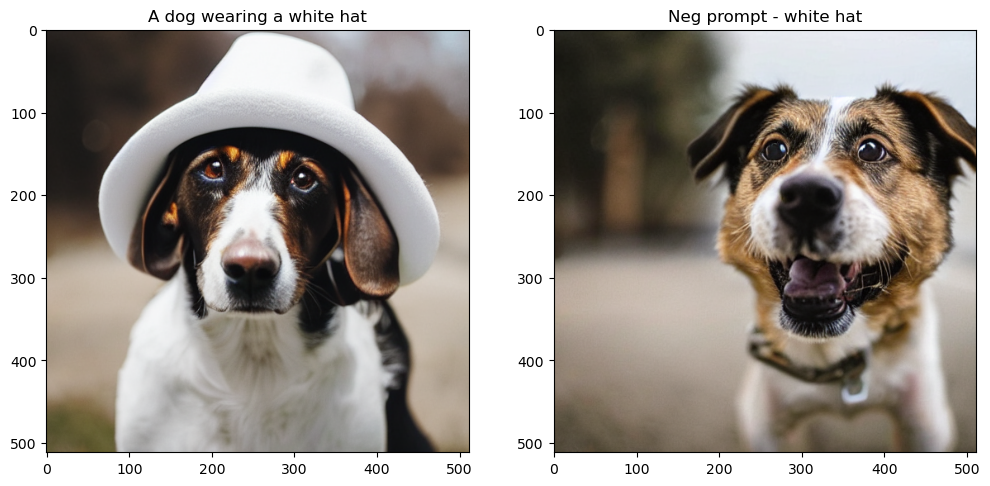

In [29]:
## Image without neg prompt
images = [None, None]
images[0] = prompt_2_img(prompts = ["A dog wearing a white hat"], neg_prompts=[""],steps=50, save_int=False)[0]
images[1] = prompt_2_img(prompts = ["A dog wearing a white hat"], neg_prompts=["White hat"],steps=50, save_int=False)[0]
    
## Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for c, img in enumerate(images): 
    axs[c].imshow(img)
    if c == 0 : axs[c].set_title(f"A dog wearing a white hat")
    else: axs[c].set_title(f"Neg prompt - white hat")

<figcaption align = "center">
        Fig. 4: Visualization of negative prompting. Left SD generated with prompt "A dog wearing a white hat" and on right the same caption with negative prompt of "White hat"
</figcaption>

<br>As we can see it can be really handy feature to fine-tune the image to your liking. You can also use it to generate pretty realistic face by being really descriptive as this [reddit post explains](https://www.reddit.com/r/StableDiffusion/comments/yqnh2c/closeup_photo_of_a_face_just_txt2img_and_lsdr/). Let's try it - 

  0%|          | 0/50 [00:00<?, ?it/s]

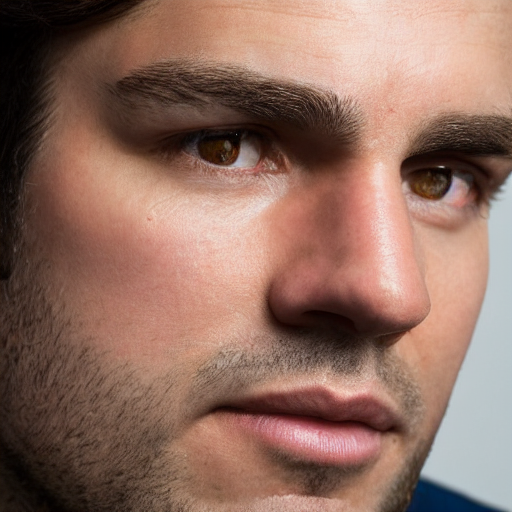

In [22]:
prompt = ['Close-up photography of the face of a 30 years old man with brown eyes, (by Alyssa Monks:1.1), by Joseph Lorusso, by Lilia Alvarado, beautiful lighting, sharp focus, 8k, high res, (pores:0.1), (sweaty:0.8), Masterpiece, Nikon Z9, Award - winning photograph']
neg_prompt = ['lowres, signs, memes, labels, text, food, text, error, mutant, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry, made by children, caricature, ugly, boring, sketch, lacklustre, repetitive, cropped, (long neck), facebook, youtube, body horror, out of frame, mutilated, tiled, frame, border, porcelain skin, doll like, doll']
images = prompt_2_img(prompts = prompt, neg_prompts=neg_prompt, steps=50, save_int=False)
images[0]

<figcaption align = "center">
        Fig. 5: An image generated using negative prompting.
</figcaption>

<br> Pretty neat! I hope this gives you some ideas on how to get going with your own variations of stable diffusion. Now lets look at another variation of Stable diffusion.

## Variation 2: Image to Image pipeline

### What is image to image pipeline?

As seen above, `prompt_2_img` functions start generating an image from a random gaussian noise, but what if we feed an initial seed image to guide the diffusion process. This is exactly how image 2 image pipeline works. Instead of purely relying on text conditioning for output image, we can use a initial seed image mix it with some noise (can be guided by a `strength` parameter) and then run the diffusion loop.

<figure align = "center">
    <img src="./img2img_example.png" style="width:100%">
<figcaption align = "center">
        Fig. 2: Image to image pipeline example.
</figcaption>
</figure>

###  Understanding image to image prompting through code

Now we are going to change the `prompt_2_img` function defined above. We will introduce two more parameter to our `prompt_2_img_i2i` function - <br>
1. `init_img` : Which is going to be the `Image` object containing the seed image <br>
2. `strength`: This parameter will take value b/w 0 and 1. Higher the value more the final image is going to look similar to the seed image.  

In [13]:
#| code-fold: false
def prompt_2_img_i2i(prompts, init_img, neg_prompts=None, g=7.5, seed=100, strength =0.8, steps=50, dim=512, save_int=False):
    """
    Diffusion process to convert prompt to image
    """
    # Converting textual prompts to embedding
    text = text_enc(prompt) 
    
    # Adding an unconditional prompt , helps in the generation process
    if not neg_prompts: uncond =  text_enc([""], text.shape[1])
    else: uncond =  text_enc(neg_prompt, text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Convert the seed image to latent
    init_latents = pil_to_latents(init_img)
    
    # Figuring initial time step based on strength
    init_timestep = int(steps * strength) 
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")
    
    # Adding noise to the latents 
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    # Computing the timestep to start the diffusion loop
    t_start = max(steps - init_timestep, 0)
    timesteps = scheduler.timesteps[t_start:].to("cuda")
    
    # Iterating through defined steps
    for i,ts in enumerate(tqdm(timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Saving intermediate images
        if save_int: 
            if not os.path.exists(f'./steps'):
                os.mkdir(f'./steps')
            latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')
            
    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

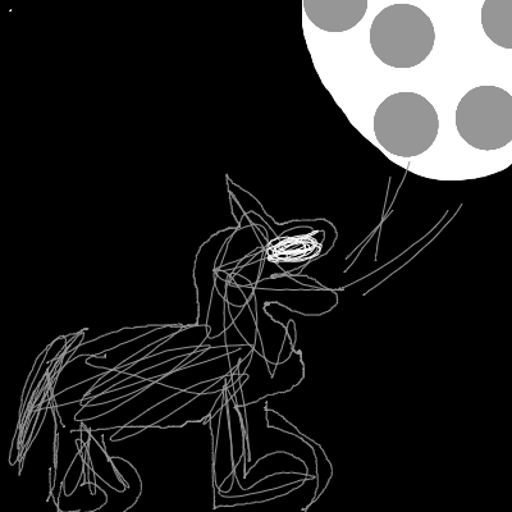

In [7]:
p = FastDownload().download('https://s3.amazonaws.com/moonup/production/uploads/1664665907257-noauth.png')
image = Image.open(p).convert('RGB').resize((512,512))
image

  0%|          | 0/40 [00:00<?, ?it/s]

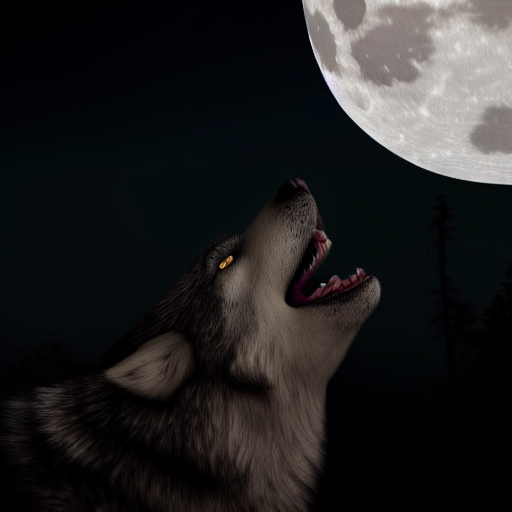

In [14]:
prompt = ["Wolf howling at the moon, photorealistic 4K"]
images = prompt_2_img_i2i(prompts = prompt, init_img = image)
images[0]

## Conclusion

I hope this gives a good overview and breaks the code to the bare minimum so that we can understand each component. Now that we have the minimum code implemented, in the next post we will see make some tweaks to the `mk_img` function to add additional functionality i.e., img2img pipeline and negative prompt.

I hope you enjoyed reading it, and feel free to use my code and try it out for generating your images. Also, if there is any feedback on the code or just the blog post, feel free to reach out on [LinkedIn](https://www.linkedin.com/in/aayushmnit/) or email me at aayushmnit@gmail.com.

## References

- [Fast.ai course - 1st Two Lessons of From Deep Learning Foundations to Stable Diffusion](https://www.fast.ai/posts/part2-2022-preview.html)
- [Stable Diffusion with 🧨 Diffusers](https://huggingface.co/blog/stable_diffusion)
- [Getting Started in the World of Stable Diffusion](https://bipinkrishnan.github.io/posts/getting-started-in-the-world-of-stable-diffusion/)
